# Training a Neural Network for Adaptive Cruise Control

Now that we have proven the correctness of an abstract system and derived a specification for the neural network, it is time to train such a neural network.

## Intro
This notebook trains a neural network for adaptive cruise control in a highly simplified setting.

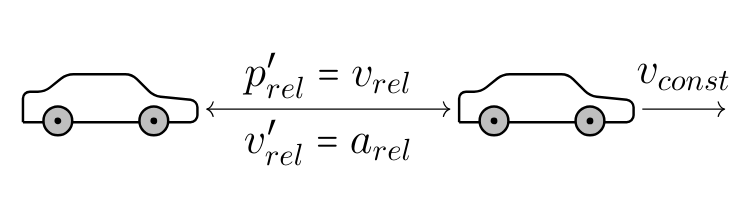

- The system is described by two variables: Relative (!) Position $p_{\text{rel}}$ and Velocity $v_{\text{rel}}$
- The Neural Network determines the acceleration of the car in the back via discrete control:
  Accelerate ($a_{\text{rel}}=-A$); No Acceleration ($a_{\text{rel}}=0$); Brake ($a_{\text{rel}}=B$)
- The dynamics of the system are given as $p_{\text{rel}}'=v_{\text{rel}},v_{\text{rel}}'=a_{\text{rel}}$ and there is a control decision at least every $0.1$ seconds
- To keep the system safe, we must ensure that the car in the back never crashes into the car in the front

## Setup

In [1]:
import libs.acc
from libs.gym_helper import *
import gymnasium as gym
from gymnasium import wrappers

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
import time
import numpy as np

set_random_seed(0)

In [2]:
# Initialize Evaluation Environment for ACC
eval_env = Monitor(gym.make('acc-discrete-v0'))

Next, we initialize the environment.  
To see, how we can implement environments, feel free to have a look at `./libs/acc.py`

#### Digression: Reward Function
We will train our agent via Reinforcement Learning.
To this end, we require a reward function which tells our agent whether its behavior is good or not.

The computation of the reward is implemented in the `step` function of the environment in `./libs/acc.py`

Unfortunately, designing good loss functions is a very complicated topic where [lots of things can go wrong](https://par.nsf.gov/servlets/purl/10424463).  
Fortunately, in our case the reward function fell from the sky:
- If the agent is still alive and well: +0.1
- If the agent crashed: -200
- If the agent's position is larger than the cutoff ($>100$): -50

## Training a bad model
To see that our NN verification actually works as inteded, we begin by training a decidedly **bad** model.
To this end, we invert the reward function, i.e. our model is rewarded for crashing and falling behind...

In [3]:
# Initialize Environment and Train Model
env1 = get_env1()
model1 = train_model1(env1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Performing some training steps...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 62       |
|    ep_rew_mean     | 93.9     |
| time/              |          |
|    fps             | 2780     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 68.8        |
|    ep_rew_mean          | 89          |
| time/                   |             |
|    fps                  | 2065        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008028011 |
|    clip_fraction        | 0.0875      |
|    clip_range           | 

### Let's see how bad it is...

In [4]:
show_run(eval_env, model1.predict, obs=[50,-8])

## Training a good model
OK, I guess we have learned our lesson...

In [9]:
# Initialize Training Environment for ACC
env = gym.make("acc-discrete-v0")
# Bad idea:
# env.unwrapped.invert_loss=True

In [10]:
# Initialize Agent
architecture = dict(pi=[64, 64, 64, 64], vf=[64, 64, 64, 64])
good_model = PPO("MlpPolicy", env, verbose=1,policy_kwargs={"activation_fn":nn.ReLU,"net_arch":architecture})

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


### Evaluation
Now that we have an agent, we can test the agent and see what reward we currently get.  
To this end, we setup a new evaluation environment and use the function `evaluate_policy`:

In [11]:
# Evaluate untrained agent
mean_reward, std_reward = evaluate_policy(good_model, eval_env, n_eval_episodes=1000, deterministic=True)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-193.37 +/- 10.14


We can also have a look at what the behavior of the agent looks like:

In [12]:
show_run(eval_env, good_model.predict)

/opt/conda/envs/versaille/lib/python3.8/site-packages/gymnasium/experimental/wrappers/rendering.py:166: UserWarning: WARN: Overwriting existing videos at /tmp/.gym-results folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /tmp/.gym-results/rl-video-episode-0.mp4.
Moviepy - Writing video /tmp/.gym-results/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /tmp/.gym-results/rl-video-episode-0.mp4


Just in case, we save a copy of the untrained neural network...

### Training
To get a better agent, we must train the model.  
This takes 5-10 minutes

In [13]:
# Train agent
good_model.learn(total_timesteps=200_000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 73       |
|    ep_rew_mean     | -91      |
| time/              |          |
|    fps             | 2143     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 83.9        |
|    ep_rew_mean          | -79.2       |
| time/                   |             |
|    fps                  | 1396        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005659003 |
|    clip_fraction        | 0.0893      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.00494     |
|    learning_rate        | 0.

Now we can evaluate again...

In [14]:
# Evaluate untrained agent
mean_reward, std_reward = evaluate_policy(good_model, eval_env, n_eval_episodes=1000, deterministic=True)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:41.00 +/- 0.00


...and look at what the policy does...

In [19]:
show_run(eval_env, good_model.predict)

Moviepy - Building video /tmp/.gym-results/rl-video-episode-0.mp4.
Moviepy - Writing video /tmp/.gym-results/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /tmp/.gym-results/rl-video-episode-0.mp4


Now we save the policy neural network to use it later...

In [16]:
extract_onnx(good_model,"good_nn.onnx")

Model saved in good_nn.onnx
